In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

[Data](https://www.kaggle.com/datasets/wanghaohan/confused-eeg/data) are collected from 10 students, each watching 10 videos. The length of each video is 2 minutes. 
First and last 30 seconds were removed (so only the middle ~1 minute is present). 
Each data point (or recording of a single student watching a single video) consists of 120+ rows, which is sampled every 0.5 seconds.

_Note that some facts about the data in the [original paper](http://www.cs.cmu.edu/~kkchang/paper/WangEtAl.2013.AIED.EEG-MOOC.pdf) do not correspond to ones in the Kaggle page, so if you need to delve deeper into this dataset, consider re-reading both descriptions and validate the data yourself._

Recording system: MindSet (single channel over frontal lobe, Fp1).
- Ground and reference are on ears.
- Initial sample rate: 512 Hz
- Additional measurements: signal quality, "attention", "meditation" (1 Hz)
- Additional measurements: power spectrum (8 Hz):
  - delta: 1-3 Hz
  - theta: 4-7 Hz
  - alpha: 8-11 Hz
  - beta: 12-29 Hz
  - gamma: 30-100 Hz
  - _In the actual data, alpha, beta, and gamma are splitted into two parts each_

Two interesting statements from the Kaggle page:
- _"This dataset is an extremely challenging data set to perform binary classification."_
- _"Past research has indicated that Theta signal is correlated with confusion level."_

# Load data

We will only load the EEG data. There is also a file with demographic information which you can also use, and which may lead to somewhat better results.

In [20]:
datapath = 'data/confused_students/EEG_data.csv'  # don't forget to change the path to yours
raw_data = pd.read_csv(datapath)
raw_data.head(20)

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
5,0.0,0.0,44.0,66.0,73.0,1786446.0,176766.0,59352.0,26157.0,15054.0,33669.0,33782.0,31750.0,0.0,0.0
6,0.0,0.0,43.0,69.0,130.0,635191.0,122446.0,90107.0,65072.0,36230.0,53019.0,62938.0,59307.0,0.0,0.0
7,0.0,0.0,40.0,61.0,-2.0,161098.0,12119.0,1963.0,809.0,1277.0,3186.0,3266.0,2518.0,0.0,0.0
8,0.0,0.0,43.0,69.0,17.0,492796.0,120998.0,63697.0,68242.0,10769.0,88403.0,73756.0,22676.0,0.0,0.0
9,0.0,0.0,47.0,69.0,-59.0,82048.0,116131.0,47317.0,26197.0,41642.0,28866.0,32551.0,41810.0,0.0,0.0


# Examine data

In [4]:
raw_data.isna().sum()

SubjectID             0
VideoID               0
Attention             0
Mediation             0
Raw                   0
Delta                 0
Theta                 0
Alpha1                0
Alpha2                0
Beta1                 0
Beta2                 0
Gamma1                0
Gamma2                0
predefinedlabel       0
user-definedlabeln    0
dtype: int64

In [5]:
raw_data.dtypes

SubjectID             float64
VideoID               float64
Attention             float64
Mediation             float64
Raw                   float64
Delta                 float64
Theta                 float64
Alpha1                float64
Alpha2                float64
Beta1                 float64
Beta2                 float64
Gamma1                float64
Gamma2                float64
predefinedlabel       float64
user-definedlabeln    float64
dtype: object

In [6]:
raw_data.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


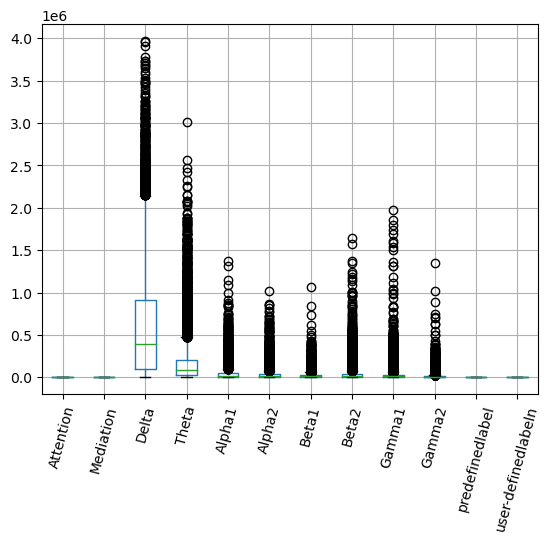

In [11]:
raw_data.drop(columns=['SubjectID', 'VideoID', 'Raw']).boxplot()
plt.xticks(rotation=75)
plt.show()

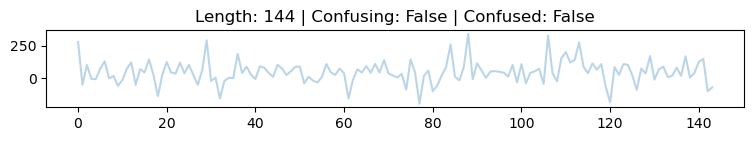

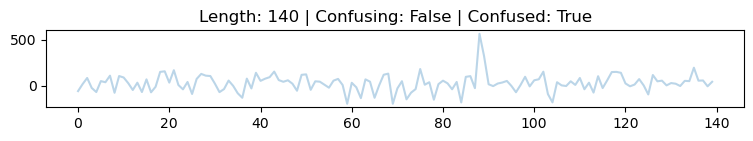

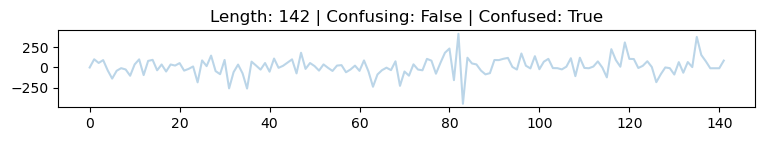

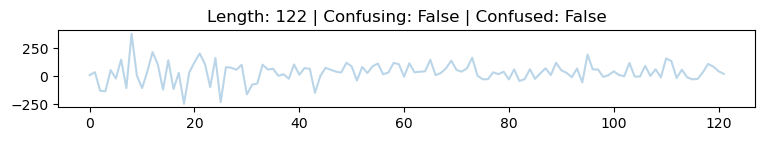

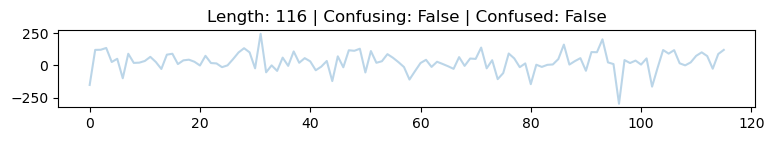

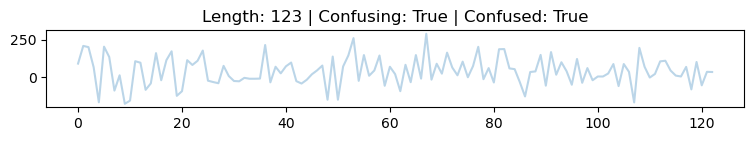

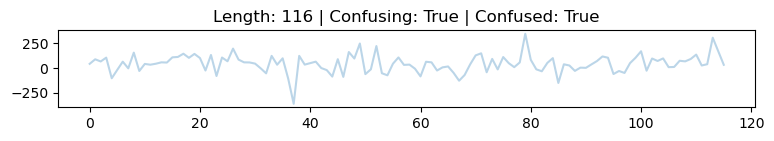

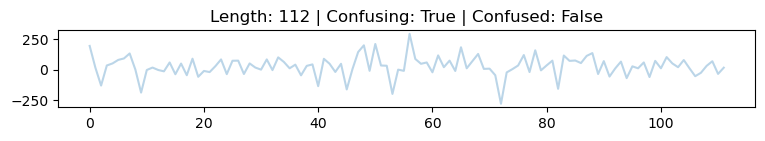

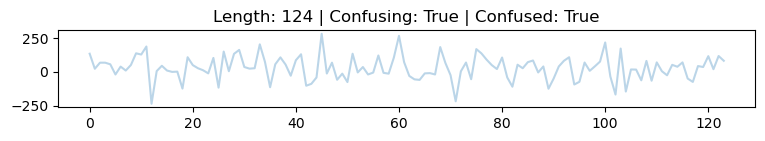

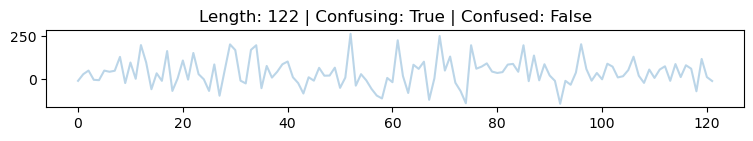

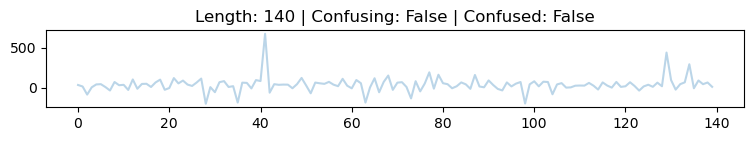

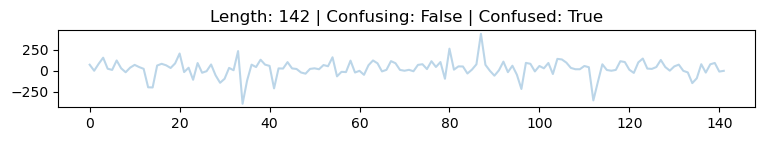

In [12]:
# the Raw data is not very useful

for i, ((sub_i, vid_i), gr) in enumerate(raw_data.groupby(['SubjectID', 'VideoID'])):
    gr = gr.reset_index(drop=True)
    assert gr['predefinedlabel'].nunique() == 1
    assert gr['user-definedlabeln'].nunique() == 1
    
    plt.figure(figsize=(9, 1))
    plt.plot(gr['Raw'], alpha=.3)
    
    is_confusing = bool(gr.loc[0, 'predefinedlabel'])
    is_confused = bool(gr.loc[0, 'user-definedlabeln'])
    plt.title(f'Length: {len(gr)} | Confusing: {is_confusing} | Confused: {is_confused}')
    plt.show()
    if i > 10:
        break

A statement from the original paper:
- _"The studentsâ€™ subjective evaluation of the confusion level and our predefined label has a modest correlation of 0.30"_.

Let's see if we get this "modest" correlation!

In [13]:
# Although Pearson correlation can be applied on binary features, it is not ideal
raw_data[['predefinedlabel', 'user-definedlabeln']].corr('pearson')

,predefinedlabel,user-definedlabeln
predefinedlabel,1.000000,-0.022824
user-definedlabeln,-0.022824,1.000000


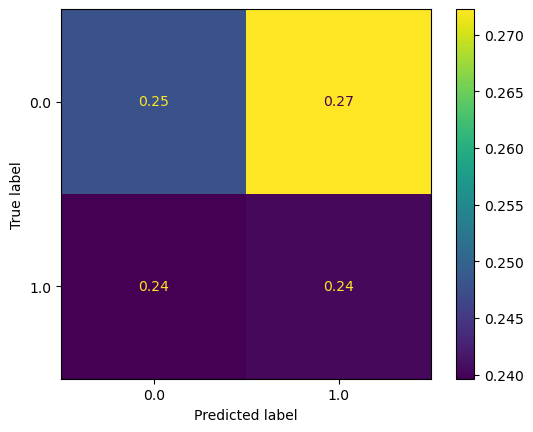

In [17]:
ConfusionMatrixDisplay.from_predictions(
    raw_data['predefinedlabel'], raw_data['user-definedlabeln'],
    normalize='all'  # comment this row to see the actual number of samples in each category
);
plt.show()

# Feature engineering

For demonstration purposes, we can limit ourselves to the same features which were used in the paper: averages of power spectrums. This will result in 100 samples: 10 students x 10 videos.

In [50]:
mean_df = []
for (sub_i, vid_i), gr in raw_data.groupby(['SubjectID', 'VideoID']):
    mean_features = {col_name: gr[col_name].mean() for col_name in gr.columns}
    mean_df.append(mean_features)
    
mean_df = pd.DataFrame.from_records(mean_df).drop(columns=['Raw'])  # not very meaningful to average a single EEG channel
mean_df

,SubjectID,VideoID,Attention,Mediation,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,55.256944,53.826389,544315.097222,124965.590278,36693.701389,25875.298611,20108.791667,40268.763889,40729.284722,16817.062500,0.0,0.0
1,0.0,1.0,43.621429,48.621429,739737.292857,161064.228571,34918.028571,25078.935714,22157.307143,37410.728571,36758.700000,14519.407143,0.0,1.0
2,0.0,2.0,43.978873,47.316901,694078.084507,149816.873239,30493.873239,21667.591549,21888.338028,36446.436620,33908.873239,14545.845070,0.0,1.0
3,0.0,3.0,51.057377,51.844262,600823.688525,162653.360656,33367.278689,26281.500000,17224.278689,43706.524590,41438.213115,16558.631148,0.0,0.0
4,0.0,4.0,55.224138,47.474138,546628.017241,126893.948276,23113.844828,17017.051724,15955.879310,36427.836207,36024.818966,14752.655172,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.0,5.0,49.813008,41.048780,935209.048780,282487.512195,70498.089431,40760.398374,28621.528455,41453.463415,54069.455285,22656.227642,1.0,1.0
96,9.0,6.0,29.620690,53.293103,780563.603448,193226.870690,74629.129310,44065.681034,23816.422414,25928.741379,17276.931034,3854.594828,1.0,0.0
97,9.0,7.0,27.633929,48.366071,733096.580357,137478.267857,37676.383929,28570.580357,14776.285714,19909.026786,18249.267857,2697.937500,1.0,0.0
98,9.0,8.0,55.548387,52.879032,914415.459677,198926.048387,42279.814516,25929.185484,20326.217742,36773.443548,45424.588710,17554.927419,1.0,1.0


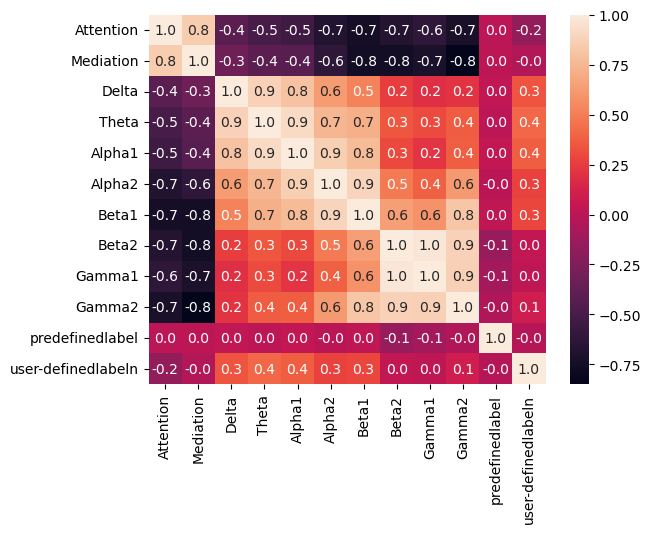

In [51]:
sns.heatmap(mean_df.drop(columns=['SubjectID', 'VideoID']).corr(), 
            annot=True, fmt='.1f')
plt.show()

We see some positive correlation between the column of interest (`user-definedlabeln`) and bandwidthes between Delta and Beta1. We also see that although the correlation between Attention and the column of interest is only 20%, we have high correlations between Attention and all bandwidthes, especially higher ones (clearly Attention was somehow calculated from them).

Do we get some clear separation in single features? Check boxplots:

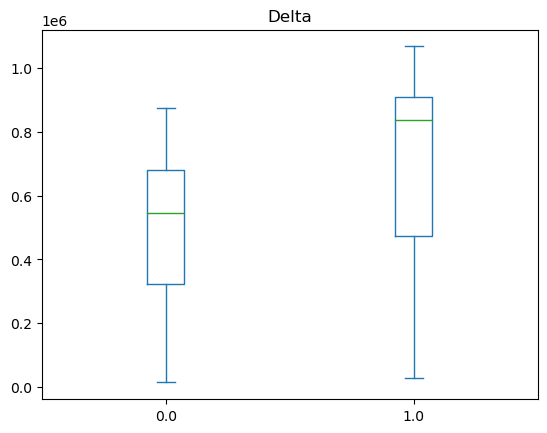

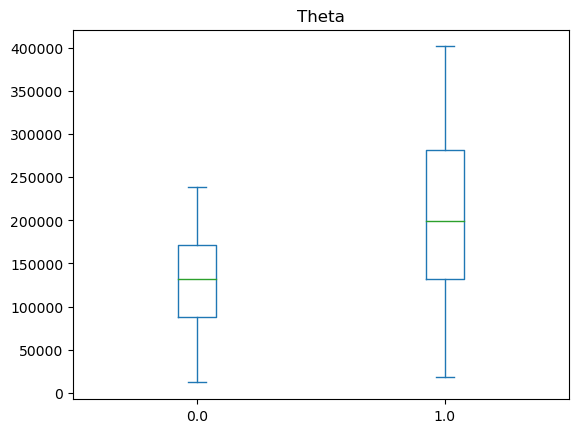

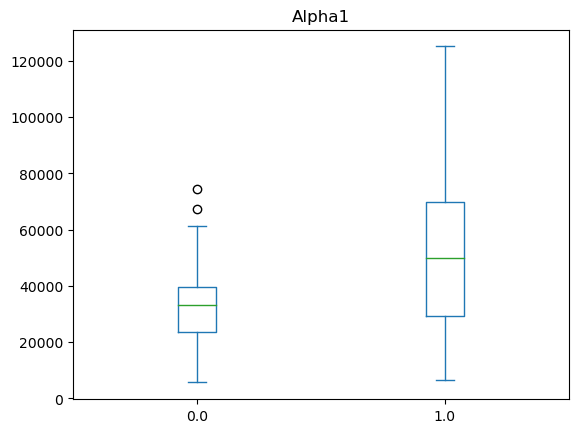

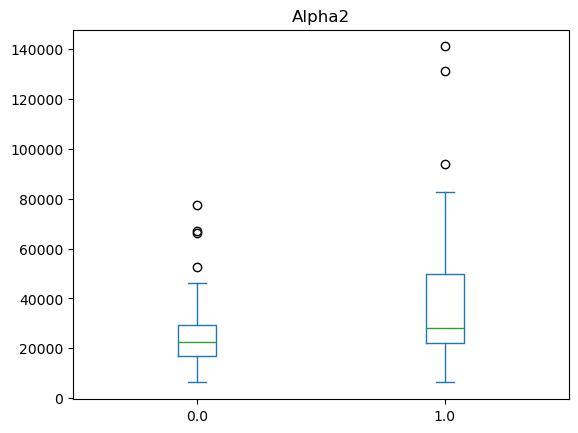

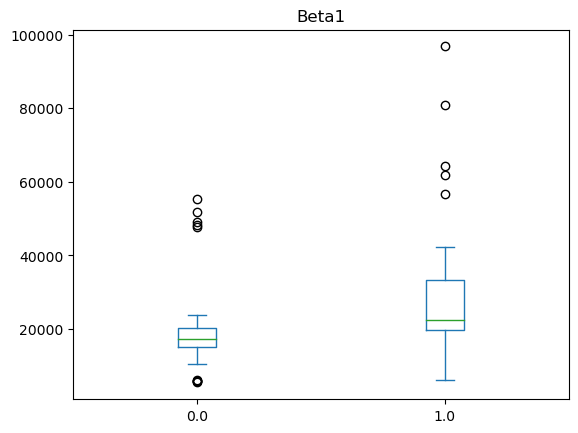

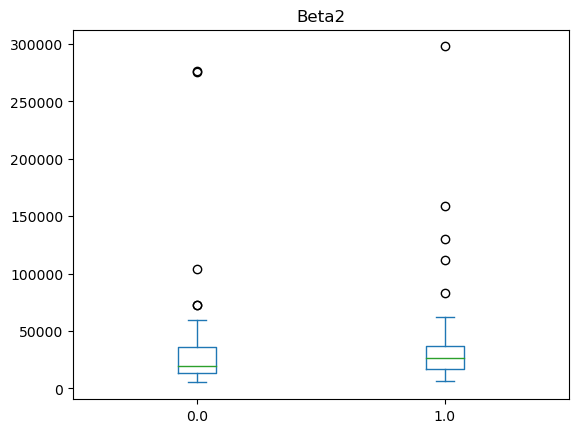

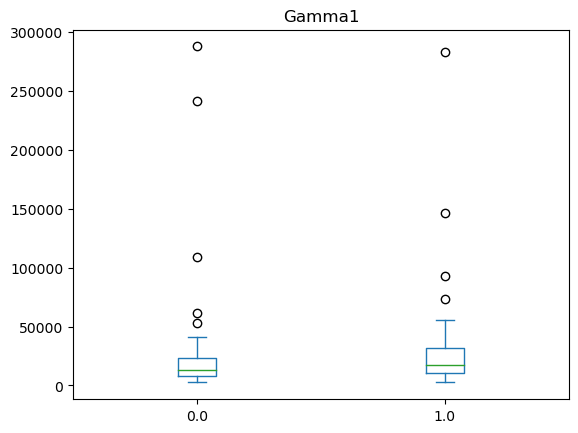

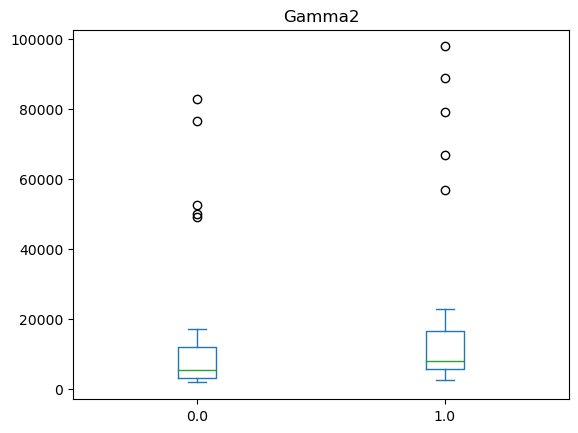

In [52]:
for col in ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']:
    mean_df.plot.box(column=col, by='user-definedlabeln')
    plt.show()

# Preparing data for training

In [53]:
data = mean_df.drop(columns=['SubjectID', 'VideoID', 'predefinedlabel'])
y = data.pop('user-definedlabeln')
x = StandardScaler().fit_transform(data)

x.shape, y.shape

((100, 10), (100,))

In [59]:
# The StandardScaler scaled each feature to have mean of 0 and SD of 1
x.mean(axis=0).round(3), x.std(axis=0).round(3)

(array([ 0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

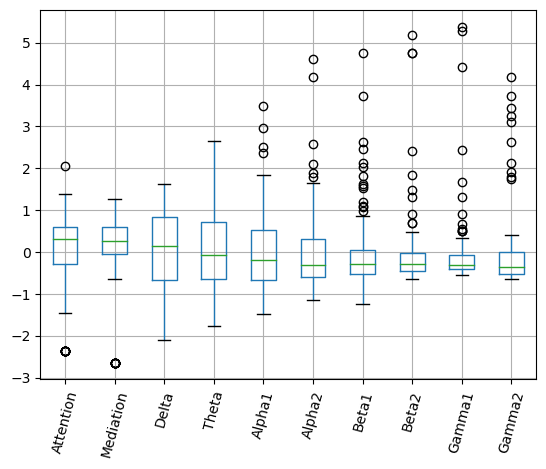

In [54]:
# Let's plot distributions of normalized data
pd.DataFrame(x, columns=data.columns).boxplot()
plt.xticks(rotation=75)
plt.show()

The [KFold](https://machinelearningmastery.com/k-fold-cross-validation/) approach is useful to see the actual performance of our model and not to just accidentally get high accuracy because of a certain split.

Stratified KFold will ensure that the ratio of all classes (in our case, 0 and 1) is the same in train and test groups.

In [60]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# n_splits of 5 equals to test_size of 20% (100/5)

tt_split_groups = []
for train_ix, test_ix in skf.split(x, y):
    x_train, y_train = x[train_ix], y[train_ix]
    x_test, y_test = x[test_ix], y[test_ix]
    tt_split_groups.append([x_train, y_train, x_test, y_test])
# To make this approach even more robust, we could generate more groups by repeating random shuffling and splitting.
# It really depends on how much time you have.

In [61]:
for group in tt_split_groups:
    print([x.shape for x in group])

[(80, 10), (80,), (20, 10), (20,)]
[(80, 10), (80,), (20, 10), (20,)]
[(80, 10), (80,), (20, 10), (20,)]
[(80, 10), (80,), (20, 10), (20,)]
[(80, 10), (80,), (20, 10), (20,)]


# Choosing an ML model

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

We will do a manual search of the best value for two parameters:
- n_estimators: the number of trees in forest
- max_depth: the maximum level of branching in each tree

In [63]:
result_scores = []

# try different max depths
for m_d in range(1, 11):  # we have 10 features
    result_scores_part = []
    # try different number of estimators
    for n_est in trange(1, 151, 10):  # 150 trees can be too much for our data already, as we only have 100 samples
        split_scores = []
        # create a model for each group in our stratified KFold groups
        for group in tt_split_groups:
            x_train, y_train, x_test, y_test = group
            
            clf = RandomForestClassifier(n_estimators=n_est, max_depth=m_d, random_state=42)
            clf.fit(x_train, y_train)
            clf.predict(x_test)
            split_scores.append(clf.score(x_test, y_test))
            
        result_scores_part.append(np.mean(split_scores))
    result_scores.append(result_scores_part)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 15/15 [00:06<00:00,  2.15it/s]


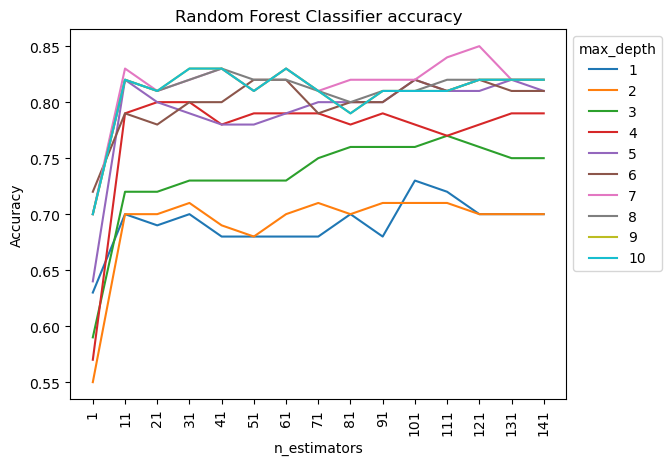

In [64]:
for m_d, result_scores_part in enumerate(result_scores):
    plt.plot(result_scores_part, label=m_d+1)
plt.title('Random Forest Classifier accuracy')
plt.xticks(range(len(result_scores_part)), range(1, 151, 10), rotation=90)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(title='max_depth', bbox_to_anchor=(1, 1))
plt.show()

In [71]:
# after identifying the best parameters from the plot, we can either repeat the search wtih smaller ranges
# or we can just go and create the final model:

split_scores = []

for i, group in enumerate(tt_split_groups):
    x_train, y_train, x_test, y_test = group

    forest = RandomForestClassifier(n_estimators=60,  # just an example
                                    max_depth=10,     # jsut an example 
                                    random_state=42)
    forest.fit(x_train, y_train)
    acc = forest.score(x_test, y_test)
    
    # you can see how "successful" it is with predictions on train data (which it saw already)!
    train_acc = forest.score(x_train, y_train)
    
    print(f'Model {i+1} | Accuracy={acc} (train accuracy={train_acc})')
    
    split_scores.append(acc)
    
# numbers look very round because we only have 20 samples
print(np.mean(split_scores))

Model 1 | Accuracy=0.85 (train accuracy=1.0)
Model 2 | Accuracy=0.85 (train accuracy=1.0)
Model 3 | Accuracy=0.8 (train accuracy=1.0)
Model 4 | Accuracy=0.85 (train accuracy=1.0)
Model 5 | Accuracy=0.75 (train accuracy=1.0)
0.82


We can also see which features were used by trees to make predictions:

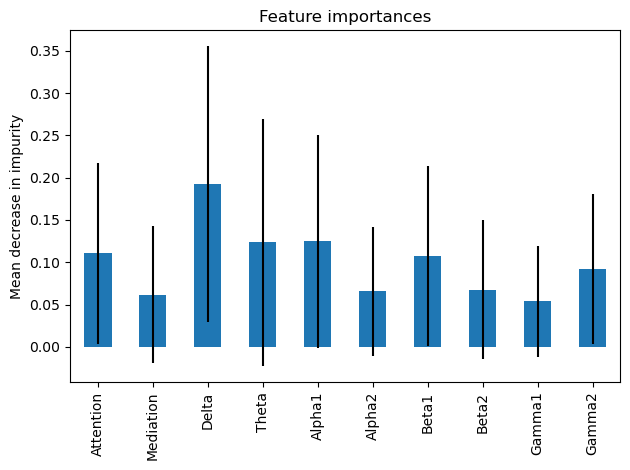

In [72]:
importances = forest.feature_importances_
importance_std = np.std([tree.feature_importances_ 
                      for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=data.columns)

forest_importances.plot.bar(yerr=importance_std)
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()
plt.show()

# The standard deviation of importance is very high, we cannot discard any feature as "not useful"

## Support Vector Machines

In [41]:
from sklearn import svm

[How kernels look like](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py)

In [73]:
svc_scores = []

# here we will change kernel shape and C parameter (which is regularization)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for c_reg in range(1, 10):
    svc_scores_part = []
    for kernel in tqdm(kernels):
        split_scores = []
        for group in tt_split_groups:
            x_train, y_train, x_test, y_test = group
            
            svc = svm.SVC(C=c_reg, kernel=kernel, random_state=42)
            svc.fit(x_train, y_train)
            svc.predict(x_test)
            split_scores.append(svc.score(x_test, y_test))
        svc_scores_part.append(np.mean(split_scores))
    svc_scores.append(svc_scores_part)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 4/4 [00:00<00:00, 83.92it/s]


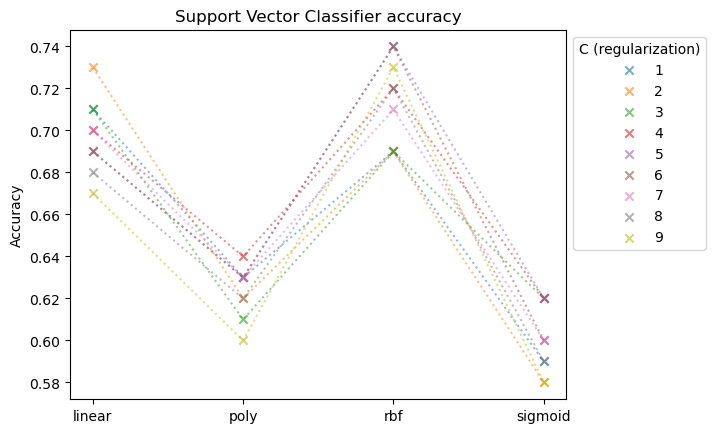

In [74]:
for m_d, svc_scores_part in enumerate(svc_scores):
    plt.scatter(range(len(kernels)), svc_scores_part, label=m_d+1, 
                marker='x', alpha=.6)
    plt.plot(range(len(kernels)), svc_scores_part, alpha=.5, ls=':')
plt.xticks(range(len(kernels)), kernels)
plt.ylabel('Accuracy')
plt.title('Support Vector Classifier accuracy')
plt.legend(title='C (regularization)', bbox_to_anchor=(1, 1))
plt.show()

# in overall, accuracies are lower than for Random Forest

## XGBoost

While Random Forest is **Bagging**, XGBoost is (you won't believe it) **Boosting**.

Bagging algorithms train decision trees in parallel and use major voting or similar way to decide which answer to take. 

Boosting algorithms train trees in a sequence, and each next tree tries to correct mistakes of the previous one.

[pip install xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

In [44]:
import xgboost

In [75]:
result_scores = []

# we can try the same parameters as for Random Forest models

for m_d in range(1, 11):
    result_scores_part = []
    for n_est in trange(1, 151, 10):
        split_scores = []
        for group in tt_split_groups:
            x_train, y_train, x_test, y_test = group
            
            clf = xgboost.XGBClassifier(objective='binary:logistic',
                                        n_estimators=n_est, max_depth=m_d, 
                                        random_state=42)
            clf.fit(x_train, y_train)
            clf.predict(x_test)
            split_scores.append(clf.score(x_test, y_test))
        result_scores_part.append(np.mean(split_scores))
    result_scores.append(result_scores_part)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 15/15 [00:02<00:00,  6.19it/s]


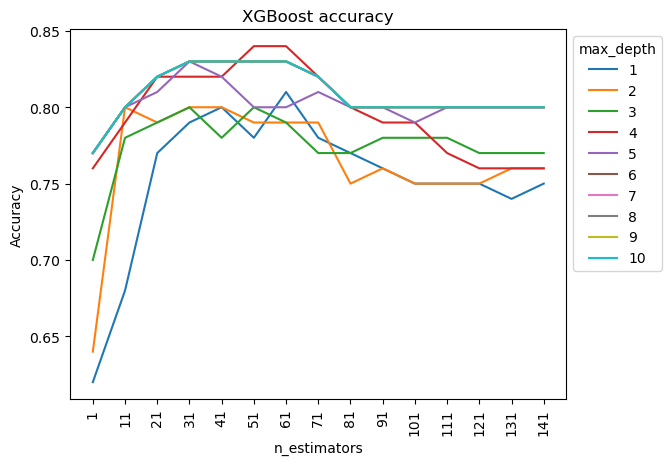

In [76]:
for m_d, result_scores_part in enumerate(result_scores):
    plt.plot(result_scores_part, label=m_d+1)
plt.xticks(range(len(result_scores_part)), range(1, 151, 10), rotation=90)
plt.title('XGBoost accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(title='max_depth', bbox_to_anchor=(1, 1))
plt.show()

In [79]:
result_scores = []

for group in tt_split_groups:
    x_train, y_train, x_test, y_test = group

    clf = xgboost.XGBClassifier(objective='binary:logistic',
                                n_estimators=60,     # only an example
                                max_depth=4,         # only an example
                                random_state=42)
    clf.fit(x_train, y_train)
    acc = clf.score(x_test, y_test)    
    train_acc = forest.score(x_train, y_train)
    print(f'Model {i+1} | Accuracy={acc} (train accuracy={train_acc})')
    
    result_scores.append(acc)
    
print(np.mean(result_scores))

# note that this model also looks less overfit from the train data perspective!

Model 5 | Accuracy=0.8 (train accuracy=0.9375)
Model 5 | Accuracy=0.9 (train accuracy=0.9375)
Model 5 | Accuracy=0.85 (train accuracy=0.9375)
Model 5 | Accuracy=0.75 (train accuracy=0.9375)
Model 5 | Accuracy=0.9 (train accuracy=1.0)
0.8400000000000001


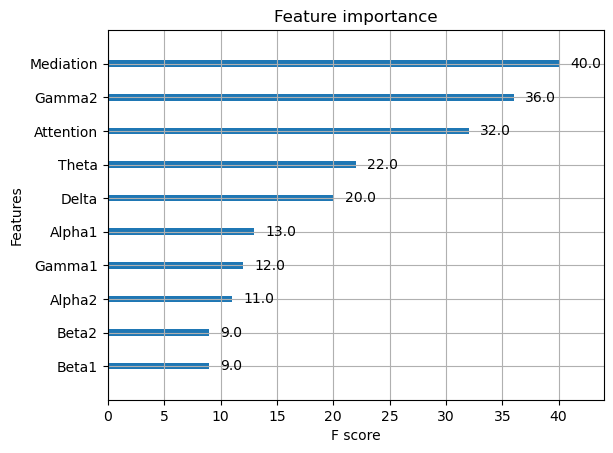

In [80]:
# As we do not have many equally important trees here, we don't have any standard devation for importance.

ax = xgboost.plot_importance(clf)

label_names = {f'f{i}': col for i, col in enumerate(data.columns)}
ax.set_yticklabels([label_names[t.get_text()] 
                    for t in ax.get_yticklabels()])
plt.show()

# Hyperparameter tuning

This process of trying out different parameter values is also called hyperparameter tuning.

In programming, the `param_name` part from `some_function(param_name=1000)` is called a parameter. However, in ML & AI context, it is called a _hyperparameter_. Parameters are changing numbers in the formula which is found by the model. So you can hear that ChatGPT has 1.5 billion parameters - this is how many variables it has in its "formula".

GridSearchCV will check _all_ combinations of hyperparameters and also apply Cross Validation for better assessment whether those are the best. If you want to check more combinations and don't have a lot of time, consider using Random Search or Bayes Search.

In [81]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100],
    'subsample': [0.5, 0.7, 1]
}

clf = xgboost.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(x, y)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.5;, score=0.850 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.5;, score=0.650 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.5;, score=0.950 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.5;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.850 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=30, su

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=0.7;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=0.7;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=0.7;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=0.7;, score=0.800 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=1;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=1;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=80, subsample=1;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rat

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1;, score=0.550 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1;, score=0.800 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=60, subsample=0.5;, score=0.750 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=60, subsample=0.5;, score=0.650 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=60, subsample=0.5;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=60, subsample=0.5;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.

[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1;, score=0.800 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.5;, score=0.850 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.5;, score=0.650 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.5;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.5;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_r

[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.5;, score=0.650 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.5;, score=0.850 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.5;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.7;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.7;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.7;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=80, subsample=0.7;, score=0.750 total time=   0.0s
[CV 1/5] END learni

[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1;, score=0.850 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1;, score=0.600 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=60, subsample=0.5;, score=0.800 total time=   0.0s
[CV 2/5] END learnin

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.800 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=0.600 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=30, subsample=0.5;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=30, subsample=0.5;, score=0.600 total time=   0.0s
[CV 3/5] END 

[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=70, subsample=1;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=70, subsample=1;, score=0.900 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=70, subsample=1;, score=0.550 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=70, subsample=1;, score=0.700 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=80, subsample=0.5;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=80, subsample=0.5;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=80, subsample=0.5;, score=0.850 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=80, subsample=0.5;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=80, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learn

[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=40, subsample=1;, score=0.550 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=40, subsample=1;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.5;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.5;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.5;, score=0.850 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.5;, score=0.650 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END l

[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=90, subsample=1;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.750 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.750 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.800 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.900 total time=   0.0s
[CV 

[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=60, subsample=1;, score=0.700 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.5;, score=0.600 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.5;, score=0.550 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.5;, score=0.800 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.5;, score=0.650 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.5;, score=0.700 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.7;, score=0.600 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=70, subsample=0.7;, score=0.850 total time=   0.0s
[CV

[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.5;, score=0.500 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.5;, score=0.500 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.5;, score=0.500 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.5;, score=0.500 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.5;, score=0.650 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.7;, score=0.500 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.7;, score=0.550 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.7;, score=0.500 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=40, subsample=0.7;, score=0.450 total time=   0.0s
[

[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.5;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.5;, score=0.750 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.7;, score=0.700 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.7;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.7;, score=0.850 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.7;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=0.7;, score=0.650 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=1;, score=0.700 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=90, subsample=1;, score=0.600 total time=   0.0s
[CV 3

[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=0.7;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=0.7;, score=0.650 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=1;, score=0.550 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=1;, score=0.600 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=1;, score=0.850 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=1;, score=0.550 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=60, subsample=1;, score=0.700 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=70, subsample=0.5;, score=0.550 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=70, subsample=0.5;, score=0.550 total time=   0.0s
[CV 3/5] EN